In [31]:
import pandas as pd
import numpy as np
import re
import os

import html2text
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import yfinance as yf

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter

In [32]:
cur_path = os.getcwd()

In [33]:
test_path = os.path.abspath('.\\datasets\\RAW_FILINGS')
#test_path

In [4]:
test_list = os.listdir(test_path)
#test_list

In [5]:
file_list2 = [str(test_path)+"\\"+file for file in test_list]
#file_list2

In [6]:
# Item 2.  Management’s Discussion and Analysis of Financial Condition and Results of Operations
def full(file_name):
    with open(file_name, 'r') as f:
        html_string = f.read()

        s = html2text.html2text(html_string)
        s_re = s.translate(str.maketrans('', '', string.punctuation))
        
        #print(s)
        s = s.replace("-"," ")
#         s_re = s_re.replace("|","")
#         s_re = s_re.replace("*","")
#         s_re = s_re.replace("•","")
#         s_re = s_re.replace("◦","")
        txt = s_re.split("\n")
        
        tmp_txt = []
        for line in txt:
            tmp_line = line.strip()
            if tmp_line != "":
                tmp_txt.append(tmp_line)
        
        return tmp_txt

In [7]:
neg_words = pd.read_csv("negdic.csv")
# neg_words

In [8]:
stopword_list = stopwords.words('english')

In [9]:
h4n = list(neg_words["H4N"].str.lower())
fn = list(neg_words["Fin_Neg"].str.lower())

In [10]:
def clean_tokenize_fullist(line, stopword_list, processed_list):
    word_list = list(filter(lambda x: x not in stopword_list and x != '' and x.isalpha(), line.split(' ')))   
    processed_list += word_list
    return processed_list

In [11]:
def nlp_scores_full(file_name):

    report = full(file_name)
    
    processed_list = []
    for line in report:
        clean_tokenize_fullist(line, stopword_list, processed_list)
    
    dict_word_freq = Counter(processed_list)
    h4n_neg_dict = {K: V for K, V in dict_word_freq.items() if K in h4n}
    fn_neg_dict = {K: V for K, V in dict_word_freq.items() if K in fn}
    
    if len(processed_list) == 0:
        return (0,0,"failure")
    else:
        h4n_prop = sum(h4n_neg_dict.values())/len(processed_list)
        fn_prop = sum(fn_neg_dict.values())/len(processed_list)
        return (h4n_prop, fn_prop,"success")

In [12]:
def nlp_scores_tfidf_full(file_name):
    
    report = full(file_name)
    
    processed_list = []
    for line in report:
        clean_tokenize_fullist(line, stopword_list, processed_list)
    
    if len(processed_list) == 0:
        return (0,0,0,"failure")
    else:
        dict_word_freq = Counter(processed_list)
        h4n_neg_dict = {K: V for K, V in dict_word_freq.items() if K in h4n}
        fn_neg_dict = {K: V for K, V in dict_word_freq.items() if K in fn}
        
        avg_word_freq = sum(dict_word_freq.values())/len(dict_word_freq.values())
        
        for h4n_K in h4n_idf_count.keys():
            if h4n_K in processed_list:
                h4n_idf_count[h4n_K] += 1
            
        for fn_K in fn_idf_count.keys():
            if fn_K in processed_list:
                fn_idf_count[fn_K] += 1
            
        return (h4n_neg_dict, fn_neg_dict, avg_word_freq, "success")

In [13]:
sp_500_return = pd.read_csv("s&p500_ret.csv")
sp_500_return["date"] = sp_500_return["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
sp_500_return.set_index("date",inplace = True)
sp_500_return_ts = sp_500_return["vw_ret_d"]

filing_df = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")
cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")

cik_df = cik_df.iloc[: , 1:]
cik_df["cik"] = cik_df["cik"].values.astype(int).astype(str)
cik_df["date"] = cik_df["date"].apply(lambda x:datetime.strptime(x,"%m/%d/%y"))
cik_df = cik_df[cik_df["date"] >= "1/1/2016"]
cik_df.sort_values(by=['cik', 'date'],inplace = True)

filing_df["CIK"] = filing_df["CIK"].values.astype(int).astype(str)

C:\Users\bruce\AppData\Local\Temp\ipykernel_19332\3914721342.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cik_df = pd.read_csv("sp500_w_addl_id_with_cik.csv")


In [14]:
cik_df

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,cik,sic,naics,gind,gsubind
41427,2016-01-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.069614,1000180,3572,334112,452020,45202030
41428,2016-02-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.022065,1000180,3572,334112,452020,45202030
41429,2016-03-31,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,0.052865,1000180,3572,334112,452020,45202030
41430,2016-04-29,82618,SANDISK CORP,80004C10,11,3,3570,SNDK,61513,1,4/20/06,5/12/16,-0.012487,1000180,3572,334112,452020,45202030
41441,2016-01-29,82581,SCHEIN HENRY INC,80640710,11,3,5047,HSIC,61494,1,3/18/15,3/31/22,-0.042670,1000228,5047,423450,351020,35102010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,2017-07-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.015026,9892,3841,339112,351010,35101010
2365,2017-08-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.000655,9892,3841,339112,351010,35101010
2366,2017-09-29,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,-0.000966,9892,3841,339112,351010,35101010
2367,2017-10-31,46877,BARD C R INC,6738310,11,1,3841,BCR,2044,1,6/12/75,1/2/18,0.020499,9892,3841,339112,351010,35101010


# get the price

In [15]:
ciks = set(cik_df["cik"].values)
tickers = set()

old_ticker = {
    'MYL':'VTRS',
    'BBT':'TFC',
    'ARNC':'HWM',
    'PCLN':'BKNG',
    'COG':'CTRA',
    'CTL':'LUMN',
    'MHFI':'SPGI',
    'CBS':'VIAC',
    'TMK':'GL',
    'KORS':'CPRI',
    'GMCR':'DPS',
    'TSO':'ANDV',
    'HRS':'LHX',
    'UTX':'RTX',
    'CBG':'CBRE',
    'SYMC':'NLOK',
    'LB':'BBWI',
    'UA':'UAA',
    'Q':'IQV',
    'DOW':'DD',
    'DWDP':'DD',
    'DLPH':'APTV',
    'BHGE':'BKR',
    'JEC':'J',
    'IR':'TT',
    'PX':'LIN',
    'HCP':'PEAK',
    'LUK':'JEF',
    'COH':'TPR',
}

for tmp_cik in ciks:
    tmp_tickers = set(cik_df[cik_df["cik"] == tmp_cik]["ticker"].values)
    if len(tmp_tickers) == 1:
        ticker = tmp_tickers.pop()
    elif len(tmp_tickers) == 2:
        ticker = tmp_tickers.pop()
        if ticker in old_ticker.keys():
            ticker = old_ticker[ticker]
    tickers.add(ticker)
    
tickers = list(tickers)

price_df = yf.download(tickers, start = "2016-01-01", end = "2021-12-31", group_by='ticker')

index = [(i,"Adj Close") for i in tickers]
price_df = price_df[index]
price_df.columns = price_df.columns.get_level_values(0)

[*********************100%***********************]  631 of 631 completed

69 Failed downloads:
- CCE: No data found for this date range, symbol may be delisted
- BLL: No data found, symbol may be delisted
- BHI: No data found for this date range, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- BRCM: No data found for this date range, symbol may be delisted
- TYC: No data found for this date range, symbol may be delisted
- ANTM: No data found, symbol may be delisted
- VIAB: No data found, symbol may be delisted
- BXLT: No data found for this date range, symbol may be delisted
- ARG: No data found for this date range, symbol may be delisted
- DISCA: No data found, symbol may be delisted
- YHOO: No data found for this date range, symbol may be delisted
- HAR: No data found for this date range, symbol may be delisted
- DO: Data doesn't exist for startDate = 1451624400, endDate = 1640926800
- TSS: No data found, symbol may be delisted
- ADS: No data found, symbol may 

In [16]:
df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])
ffile = pd.read_csv(cur_path+"/datasets/FILINGS_METADATA.csv")

f_titles = ffile['filename'].values


#sp_ciks = [str(x) for x in set(df["cik"].values)]
sp_ciks = list(set(df["cik"].values))
n_comp = len(sp_ciks)
flag_first_report = pd.DataFrame(np.zeros([25,n_comp]),columns=sp_ciks)
flag_first_report  #It's a table records if a report has been processed or not


#Change the type of date in df to datetime
date_datetime = [datetime.strptime(x,"%m/%d/%Y").date() for x in df['date'].values]
df["date_datetime"] = date_datetime
time_adj = [datetime.strptime(x,"%m/%d/%Y").date() for x in set(df['date'].values)]
time_adj.sort()

C:\Users\bruce\AppData\Local\Temp\ipykernel_19332\1557415716.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sp500_w_addl_id_with_cik_16_21.csv", index_col=[0])


In [17]:
# calculate the excess return at the filing date

In [18]:
def check_file(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = ffile[ffile['filename']==f_title]['CIK'].values[0]
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]

    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    report_t = datetime.strptime(report_str,"%m/%d/%Y").date()
    cik = int(cik_str)
    i=0
    while(file_t > time_adj[i]):
        i += 1
    last_adj_date = time_adj[i-1]
    ciks = df[df["date_datetime"]==last_adj_date]['cik'].values
    if cik not in ciks:
        #print(str(cik)," is not in ciks")
        return False
    else:
        yy = report_t.year - 2016
        mm = (report_t.month - 1) // 3
        flag_i = yy*4 + mm + 1
        if flag_first_report.loc[flag_i, cik] != 0:
            #print("Not the first report for this report period", report_str)
            return False
        else:
            flag_first_report.loc[flag_i, cik] = 1
            #print("let's apply NLP to cik = ", cik_str, ", file with report period", report_str)
            return True
        
def info(f_title):
    date_str = ffile[ffile['filename']==f_title]['Date'].values[0]
    cik_str = str(ffile[ffile['filename']==f_title]['CIK'].values[0])
    report_str = ffile[ffile['filename']==f_title]['Period of Report'].values[0]
    filing_name_str = ffile[ffile['filename']==f_title]['filename'].values[0]
    file_t = datetime.strptime(date_str,"%m/%d/%Y").date()
    return [cik_str, file_t,filing_name_str]

In [19]:
ffile

,CIK,Company,Type,Date,complete_text_file_link,html_index,Filing Date,Period of Report,SIC,htm_file_link,State of Inc,State location,Fiscal Year End,filename
0,1000180,SANDISK CORP,10-K,2/12/2016,https://www.sec.gov/Archives/edgar/data/100018...,https://www.sec.gov/Archives/edgar/data/100018...,2/12/2016,1/3/2016,3572,https://www.sec.gov/Archives/edgar/data/100018...,DE,CA,1229,1000180_10K_2016_0001000180-16-000068.htm
1,1000228,HENRY SCHEIN INC,10-K,2/10/2016,https://www.sec.gov/Archives/edgar/data/100022...,https://www.sec.gov/Archives/edgar/data/100022...,2/10/2016,12/26/2015,5047,https://www.sec.gov/Archives/edgar/data/100022...,DE,NY,1229,1000228_10K_2015_0001000228-16-000042.htm
2,1000697,WATERS CORP /DE/,10-K,2/26/2016,https://www.sec.gov/Archives/edgar/data/100069...,https://www.sec.gov/Archives/edgar/data/100069...,2/26/2016,12/31/2015,3826,https://www.sec.gov/Archives/edgar/data/100069...,DE,MA,1231,1000697_10K_2015_0001193125-16-480594.htm
3,1001082,DISH Network CORP,10-K,2/18/2016,https://www.sec.gov/Archives/edgar/data/100108...,https://www.sec.gov/Archives/edgar/data/100108...,2/18/2016,12/31/2015,4841,https://www.sec.gov/Archives/edgar/data/100108...,NV,CO,1231,1001082_10K_2015_0001558370-16-003267.htm
4,1001250,ESTEE LAUDER COMPANIES INC,10-Q,2/5/2016,https://www.sec.gov/Archives/edgar/data/100125...,https://www.sec.gov/Archives/edgar/data/100125...,2/5/2016,12/31/2015,2844,https://www.sec.gov/Archives/edgar/data/100125...,DE,NY,630,1001250_10Q_2015_0001104659-16-094265.htm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13964,96223,Jefferies Financial Group Inc.,10-Q,10/8/2021,https://www.sec.gov/Archives/edgar/data/96223/...,https://www.sec.gov/Archives/edgar/data/96223/...,10/8/2021,8/31/2021,6211,https://www.sec.gov/Archives/edgar/data/96223/...,NY,NY,1130,96223_10Q_2021_0000096223-21-000039.htm
13965,96943,TELEFLEX INC,10-Q,10/28/2021,https://www.sec.gov/Archives/edgar/data/96943/...,https://www.sec.gov/Archives/edgar/data/96943/...,10/28/2021,9/26/2021,3841,https://www.sec.gov/Archives/edgar/data/96943/...,DE,PA,1231,96943_10Q_2021_0000096943-21-000113.htm
13966,97210,"TERADYNE, INC",10-Q,11/5/2021,https://www.sec.gov/Archives/edgar/data/97210/...,https://www.sec.gov/Archives/edgar/data/97210/...,11/5/2021,10/3/2021,3825,https://www.sec.gov/Archives/edgar/data/97210/...,MA,MA,1231,97210_10Q_2021_0001193125-21-321554.htm
13967,97476,TEXAS INSTRUMENTS INC,10-Q,10/27/2021,https://www.sec.gov/Archives/edgar/data/97476/...,https://www.sec.gov/Archives/edgar/data/97476/...,10/27/2021,9/30/2021,3674,https://www.sec.gov/Archives/edgar/data/97476/...,DE,TX,1231,97476_10Q_2021_0000097476-21-000032.htm


In [20]:
f_titles = test_list[:1000]
#f_titles = test_list

In [21]:
tfidf_elements = dict()
h4n_idf_count = {word: 0 for word in h4n}
fn_idf_count = {word: 0 for word in fn}

for f_title in f_titles:
    file_route = str(test_path)+"\\"+f_title
    h4n_neg_dict, fn_neg_dict, avg_word_freq, status = nlp_scores_tfidf_full(file_route) # automatically updated counts
    tfidf_elements[file_route] = (h4n_neg_dict, fn_neg_dict, avg_word_freq, status)

In [22]:
data_list = []
N = len(f_titles)

for f_title in f_titles:
    
    print(f_title)
    if(check_file(f_title)):
        tmp_cik,tmp_filing_date,file_name = info(f_title)
        tmp_ticker = cik_df[cik_df["cik"] == tmp_cik]["ticker"].values[-1]
        tmp_filing_date_str = datetime.strftime(tmp_filing_date, "%Y-%m-%d")
        price_ts = price_df[tmp_ticker]
        
        if len(price_ts) == 0:
            pass
        try:
            start_index = price_ts.index.get_loc(tmp_filing_date_str)
            tmp_price_ts = price_ts.iloc[start_index:start_index+4].values
            
            start_index_sp500 = sp_500_return_ts.index.get_loc(tmp_filing_date_str)
            tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
            tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
            
        
        # if filing date isn't a trading day, simply find the 4 cloest trading days 
        except KeyError:
            print("no data on ",tmp_filing_date_str)
            #price_ts_2 = yf.download(tmp_ticker, start = tmp_filing_date_str, end = "2021-12-31", group_by='ticker')["Adj Close"]
            price_ts_2 = price_ts[price_ts.index >= pd.to_datetime(tmp_filing_date_str)]
            if len(price_ts_2) == 0:
                continue
            else:
                start_date = price_ts_2.index[0].date()
                start_date_str = datetime.strftime(start_date ,"%Y-%m-%d")

                tmp_price_ts = price_ts_2[:4]
                start_index_sp500 = sp_500_return_ts.index.get_loc(start_date_str)
                tmp_sp_500_return_ts = sp_500_return_ts[start_index_sp500+1:start_index_sp500+4].values
                tmp_sp_500_3d_return = np.prod(tmp_sp_500_return_ts + 1) - 1
        
        if np.isnan(tmp_price_ts).all():
            continue
        tmp_return = tmp_price_ts[-1]/tmp_price_ts[0]-1
        excess_return = tmp_return - tmp_sp_500_3d_return
        
        file_route = str(test_path)+"\\"+file_name
        
        h4n_neg_dict, fn_neg_dict, avg_word_freq, status = tfidf_elements[file_route]
        h4n_weight = 0
        fn_weight = 0

        if status != "failure":
            for K in h4n_neg_dict:
                if h4n_neg_dict[K] >=1 :
                    h4n_weight += (1+np.log(h4n_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/h4n_idf_count[K])

            for K in fn_neg_dict:
                if fn_neg_dict[K] >=1: 
                    fn_weight += (1+np.log(fn_neg_dict[K]))/(1+np.log(avg_word_freq))*np.log(N/fn_idf_count[K])
        
            data_list.append((tmp_cik, tmp_filing_date, file_name, excess_return, h4n_weight, fn_weight))

1000180_10K_2016_0001000180-16-000068.htm
no data on  2016-02-12
1000180_10Q_2016_0001000180-16-000094.htm
no data on  2016-05-02
1000228_10K_2015_0001000228-16-000042.htm
no data on  2016-02-10
1000228_10K_2016_0001000228-17-000011.htm
no data on  2017-02-21
1000228_10K_2018_0001000228-18-000012.htm
no data on  2018-02-21
1000228_10K_2018_0001000228-19-000015.htm
no data on  2019-02-20
1000228_10K_2019_0001000228-20-000018.htm
no data on  2020-02-20
1000228_10K_2020_0001000228-21-000019.htm
no data on  2021-02-17
1000228_10Q_2016_0001000228-16-000066.htm
no data on  2016-05-03
1000228_10Q_2016_0001000228-16-000090.htm
no data on  2016-08-04
1000228_10Q_2016_0001000228-16-000102.htm
1000228_10Q_2017_0001000228-17-000025.htm
no data on  2017-05-09
1000228_10Q_2017_0001000228-17-000049.htm
no data on  2017-08-08
1000228_10Q_2017_0001000228-17-000058.htm
no data on  2017-11-06
1000228_10Q_2018_0001000228-18-000022.htm
no data on  2018-05-08
1000228_10Q_2018_0001000228-18-000039.htm
no dat

no data on  2021-08-06
1002910_10Q_2021_0001002910-21-000113.htm
no data on  2021-11-04
1004155_10K_2015_0001004155-16-000098.htm
no data on  2016-02-11
1004155_10K_2016_0000092122-17-000007.htm
1004155_10K_2017_0000092122-18-000012.htm
1004155_10K_2018_0000092122-19-000006.htm
1004155_10K_2019_0000092122-20-000017.htm
1004155_10K_2020_0000092122-21-000006.htm
1004155_10Q_2016_0001004155-16-000116.htm
no data on  2016-05-04
1004155_10Q_2016_0001004155-16-000202.htm
no data on  2016-07-26
1004155_10Q_2016_0001004155-16-000224.htm
1004155_10Q_2017_0000092122-17-000024.htm
1004155_10Q_2017_0000092122-17-000065.htm
1004155_10Q_2017_0000092122-17-000076.htm
1004155_10Q_2018_0000092122-18-000027.htm
1004155_10Q_2018_0000092122-18-000050.htm
1004155_10Q_2018_0000092122-18-000062.htm
1004155_10Q_2019_0000092122-19-000016.htm
1004155_10Q_2019_0000092122-19-000037.htm
1004155_10Q_2019_0000092122-19-000053.htm
1004155_10Q_2020_0000092122-20-000042.htm
1004155_10Q_2020_0000092122-20-000057.htm
100

no data on  2017-02-15
1012100_10K_2017_0001628280-18-001957.htm
no data on  2018-02-21
1012100_10K_2018_0001628280-19-001538.htm
no data on  2019-02-19
1012100_10K_2019_0001628280-20-002658.htm
no data on  2020-03-02
1012100_10K_2020_0001628280-21-003329.htm
no data on  2021-02-25
1012100_10Q_2016_0001564590-16-017282.htm
no data on  2016-05-02
1012100_10Q_2016_0001564590-16-021907.htm
no data on  2016-08-01
1012100_10Q_2016_0001564590-16-026558.htm
no data on  2016-10-31
1012100_10Q_2017_0001564590-17-010132.htm
no data on  2017-05-10
1012100_10Q_2017_0001628280-17-008418.htm
no data on  2017-08-09
1012100_10Q_2017_0001628280-17-011291.htm
no data on  2017-11-09
1012100_10Q_2018_0001628280-18-006036.htm
no data on  2018-05-07
1012100_10Q_2018_0001628280-18-010542.htm
no data on  2018-08-06
1012100_10Q_2018_0001628280-18-013405.htm
no data on  2018-11-02
1012100_10Q_2019_0001628280-19-005496.htm
no data on  2019-05-01
1012100_10Q_2019_0001628280-19-009820.htm
no data on  2019-08-02
10

no data on  2019-02-21
101778_10K_2019_0000101778-20-000023.htm
no data on  2020-02-20
101778_10K_2020_0000101778-21-000018.htm
no data on  2021-02-23
101778_10Q_2016_0000101778-16-000067.htm
no data on  2016-05-05
101778_10Q_2016_0000101778-16-000079.htm
no data on  2016-08-04
101778_10Q_2016_0000101778-16-000103.htm
no data on  2016-11-03
101778_10Q_2017_0000101778-17-000078.htm
no data on  2017-05-05
101778_10Q_2017_0000101778-17-000108.htm
no data on  2017-08-03
101778_10Q_2017_0000101778-17-000121.htm
no data on  2017-11-02
101778_10Q_2018_0000101778-18-000091.htm
no data on  2018-05-03
101778_10Q_2018_0000101778-18-000107.htm
no data on  2018-08-02
101778_10Q_2018_0000101778-18-000118.htm
no data on  2018-11-08
101778_10Q_2019_0000101778-19-000070.htm
no data on  2019-05-02
101778_10Q_2019_0000101778-19-000093.htm
no data on  2019-08-08
101778_10Q_2019_0000101778-19-000113.htm
no data on  2019-11-07
101778_10Q_2020_0000101778-20-000081.htm
no data on  2020-05-07
101778_10Q_2020_0

no data on  2016-11-09
1024305_10Q_2016_0001024305-17-000005.htm
no data on  2017-02-09
1024305_10Q_2017_0001024305-17-000035.htm
no data on  2017-05-10
1024305_10Q_2017_0001024305-17-000125.htm
no data on  2017-11-09
1024305_10Q_2017_0001024305-18-000006.htm
no data on  2018-02-08
1024305_10Q_2018_0001024305-18-000015.htm
no data on  2018-05-09
1024305_10Q_2018_0001024305-18-000068.htm
no data on  2018-11-07
1024305_10Q_2018_0001024305-19-000021.htm
no data on  2019-02-08
1024305_10Q_2019_0001024305-19-000052.htm
no data on  2019-05-08
1024305_10Q_2019_0001024305-19-000126.htm
no data on  2019-11-06
1024305_10Q_2019_0001024305-20-000016.htm
no data on  2020-02-05
1024305_10Q_2020_0001024305-20-000049.htm
no data on  2020-05-11
1024305_10Q_2020_0001024305-20-000110.htm
1024305_10Q_2020_0001024305-21-000017.htm
1024305_10Q_2021_0001024305-21-000041.htm
1024305_10Q_2021_0001024305-21-000094.htm
1024478_10K_2016_0001024478-16-000071.htm
no data on  2016-11-15
1024478_10K_2017_0001024478-1

no data on  2019-11-07
1035002_10Q_2020_0001035002-20-000016.htm
no data on  2020-04-29
1035002_10Q_2020_0001035002-20-000041.htm
no data on  2020-07-31
1035002_10Q_2020_0001035002-20-000053.htm
no data on  2020-10-28
1035002_10Q_2021_0001035002-21-000068.htm
no data on  2021-04-30
1035002_10Q_2021_0001035002-21-000102.htm
no data on  2021-07-29
1035002_10Q_2021_0001035002-21-000118.htm
no data on  2021-10-27
1035267_10K_2015_0001035267-16-000130.htm
no data on  2016-02-02
1035267_10K_2016_0001035267-17-000021.htm
no data on  2017-02-06
1035267_10K_2017_0001035267-18-000013.htm
no data on  2018-02-02
1035267_10K_2018_0001035267-19-000012.htm
no data on  2019-02-04
1035267_10K_2019_0001035267-20-000032.htm
no data on  2020-02-07
1035267_10K_2020_0001035267-21-000028.htm
no data on  2021-02-10
1035267_10Q_2016_0001035267-16-000174.htm
no data on  2016-04-19
1035267_10Q_2016_0001035267-16-000215.htm
no data on  2016-07-20
1035267_10Q_2016_0001035267-16-000240.htm
no data on  2016-10-19
10

no data on  2019-02-21
1037868_10K_2019_0001193125-20-043133.htm
no data on  2020-02-20
1037868_10K_2020_0001037868-21-000007.htm
no data on  2021-02-18
1037868_10Q_2016_0001193125-16-577428.htm
no data on  2016-05-04
1037868_10Q_2016_0001193125-16-671811.htm
no data on  2016-08-04
1037868_10Q_2016_0001193125-16-758769.htm
no data on  2016-11-03
1037868_10Q_2017_0001193125-17-162231.htm
no data on  2017-05-08
1037868_10Q_2017_0001193125-17-245574.htm
no data on  2017-08-02
1037868_10Q_2017_0001193125-17-330793.htm
no data on  2017-11-02
1037868_10Q_2018_0001193125-18-150560.htm
no data on  2018-05-03
1037868_10Q_2018_0001193125-18-236366.htm
no data on  2018-08-02
1037868_10Q_2018_0001193125-18-316887.htm
no data on  2018-11-02
1037868_10Q_2019_0001193125-19-134763.htm
no data on  2019-05-02
1037868_10Q_2019_0001193125-19-211704.htm
no data on  2019-08-02
1037868_10Q_2019_0001193125-19-281864.htm
no data on  2019-11-01
1037868_10Q_2020_0001037868-20-000006.htm
no data on  2020-08-04
10

In [23]:
data_list

[('1000228',
  datetime.date(2016, 2, 10),
  '1000228_10K_2015_0001000228-16-000042.htm',
  0.008403508371645163,
  178.35172476414692,
  167.42402297161718),
 ('1000228',
  datetime.date(2017, 2, 21),
  '1000228_10K_2016_0001000228-17-000011.htm',
  0.0018750374580918105,
  173.44165836191885,
  154.68378529378148),
 ('1000228',
  datetime.date(2018, 2, 21),
  '1000228_10K_2018_0001000228-18-000012.htm',
  -0.04330361521001891,
  211.9197848583879,
  173.71383577244856),
 ('1000228',
  datetime.date(2019, 2, 20),
  '1000228_10K_2018_0001000228-19-000015.htm',
  -0.00967989514146006,
  249.1665501363277,
  225.0907758343155),
 ('1000228',
  datetime.date(2020, 2, 20),
  '1000228_10K_2019_0001000228-20-000018.htm',
  -0.011464340586036958,
  264.1479710973609,
  240.41938982936233),
 ('1000228',
  datetime.date(2021, 2, 17),
  '1000228_10K_2020_0001000228-21-000019.htm',
  0.03138711015057638,
  218.0157262931028,
  183.4673708298203),
 ('1000228',
  datetime.date(2016, 5, 3),
  '100022

In [24]:
result_list = pd.DataFrame(data_list, columns = ["cid", "date", "file_name", "excess_return", "h4n_tfidf", "fn_tfidf"])
result_list

,cid,date,file_name,excess_return,h4n_tfidf,fn_tfidf
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,0.008404,178.351725,167.424023
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,0.001875,173.441658,154.683785
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.043304,211.919785,173.713836
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,249.166550,225.090776
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,264.147971,240.419390
...,...,...,...,...,...,...
852,1041061,2020-08-05,1041061_10Q_2020_0001041061-20-000053.htm,-0.006472,46.839611,45.370049
853,1041061,2020-11-05,1041061_10Q_2020_0001041061-20-000064.htm,0.012394,48.737323,45.528487
854,1041061,2021-05-05,1041061_10Q_2021_0001041061-21-000022.htm,0.001984,36.946922,26.884763
855,1041061,2021-08-05,1041061_10Q_2021_0001041061-21-000042.htm,-0.006449,43.982889,31.183435


In [25]:
result_list.to_csv("Full_Results.csv")

In [26]:
result_df = result_list.copy()

In [27]:
result_df['h4n_qrank']= pd.qcut(result_df["h4n_tfidf"], q = 5, labels = False)
result_df['fn_qrank']= pd.qcut(result_df["fn_tfidf"], q = 5, labels = False)

In [28]:
result_df

,cid,date,file_name,excess_return,h4n_tfidf,fn_tfidf,h4n_qrank,fn_qrank
0,1000228,2016-02-10,1000228_10K_2015_0001000228-16-000042.htm,0.008404,178.351725,167.424023,4,4
1,1000228,2017-02-21,1000228_10K_2016_0001000228-17-000011.htm,0.001875,173.441658,154.683785,4,4
2,1000228,2018-02-21,1000228_10K_2018_0001000228-18-000012.htm,-0.043304,211.919785,173.713836,4,4
3,1000228,2019-02-20,1000228_10K_2018_0001000228-19-000015.htm,-0.009680,249.166550,225.090776,4,4
4,1000228,2020-02-20,1000228_10K_2019_0001000228-20-000018.htm,-0.011464,264.147971,240.419390,4,4
...,...,...,...,...,...,...,...,...
852,1041061,2020-08-05,1041061_10Q_2020_0001041061-20-000053.htm,-0.006472,46.839611,45.370049,1,1
853,1041061,2020-11-05,1041061_10Q_2020_0001041061-20-000064.htm,0.012394,48.737323,45.528487,1,1
854,1041061,2021-05-05,1041061_10Q_2021_0001041061-21-000022.htm,0.001984,36.946922,26.884763,0,0
855,1041061,2021-08-05,1041061_10Q_2021_0001041061-21-000042.htm,-0.006449,43.982889,31.183435,1,1


In [29]:
plot_df_h4n = result_df.groupby(by = ['h4n_qrank'])['excess_return'].median()
plot_df_fn = result_df.groupby(by = ['fn_qrank'])['excess_return'].median()

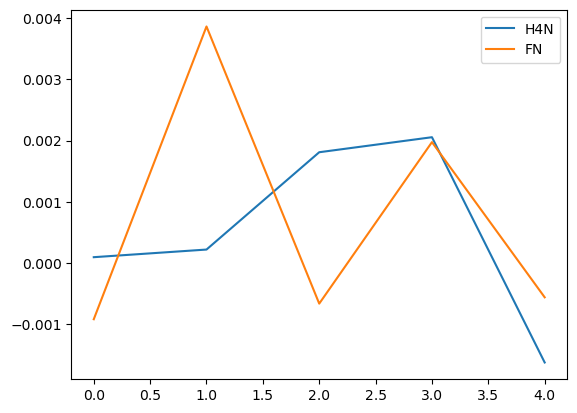

In [30]:
plt.plot(plot_df_h4n, label = 'H4N')
plt.plot(plot_df_fn, label = 'FN')
plt.legend()
plt.show()